In [1]:
from deepinv.physics.generator import DiffractionBlurGenerator
from src.utils.display_utils import show_images
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transform
from product_convolution import *

In [2]:
device = 'cuda'
dtype = torch.float32
torch.set_default_device(device)
torch.set_default_dtype(dtype)

## Plot utils

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from torch import Tensor
import numpy as np
from typing import List, Optional, Tuple, Union
import warnings
warnings.filterwarnings("ignore", module="matplotlib\..*")

_TensorArray = Union[Tensor, np.ndarray]

def to_numpy_image(input):
    if isinstance(input, Tensor):
        if input.dim() == 3:
            return input.detach().cpu().permute(1, 2, 0).numpy()
        elif input.dim() == 4:
            return input.detach().cpu().permute(0, 2, 3, 1).numpy()

    elif isinstance(input, np.ndarray):
        print("Warning: input is already a numpy array")
        return input
    else:
        raise ValueError(f"Cannot convert {type(input)} to numpy image")
def show_images(
    imgs: Union[_TensorArray, List[_TensorArray], Tuple[_TensorArray]],
    title: List[str] = None,
    suptitle: str = None,
    ncols: int = None,
    colorbar: Optional[bool] = False,
    cmap: str = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    savename: Optional[str] = None,
    figsize: Optional[int] = 3,
    interpolation: Optional[str] = None,
):

    if isinstance(imgs, List) or isinstance(imgs, Tuple):
        if isinstance(imgs[0], np.ndarray):
            imgs = np.concatenate(imgs, axis=0)
        elif isinstance(imgs[0], torch.Tensor):
            imgs = to_numpy_image(torch.cat(imgs, dim=0))
    else:
        imgs = to_numpy_image(imgs)

    if imgs.ndim == 3:
        H, W, C = imgs.shape
        B = 1
    elif imgs.ndim == 4:
        B, H, W, C = imgs.shape

    if (ncols is not None) and (B % ncols == 0):
        nrows = B // ncols
    else:
        nrows = 1
        ncols = B
    offset = 0 if not colorbar else 0.75
    fig = plt.figure(figsize=(ncols * (figsize + offset), nrows * figsize))
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows)
    gs.update(wspace=0.025, hspace=0.025)

    if cmap is None:
        cmap = "gray" if C == 1 else None
    i = 0

    if title is None:
        title = [""]
    if len(title) != B:
        title += [""] * (B - len(title))
    with warnings.catch_warnings():
        if nrows > 1 and ncols > 1:
            for r in range(nrows):
                for c in range(ncols):
                    axs = plt.subplot(gs[r, c])
                    im = axs.imshow(
                        imgs[i],
                        vmin=vmin,
                        vmax=vmax,
                        cmap=cmap,
                        interpolation=interpolation,
                    )
                    axs.set_xticks([])
                    axs.set_yticks([])
                    if colorbar:
                        divider = make_axes_locatable(axs)
                        cax = divider.append_axes("right", size="3%", pad=0.1)
                        plt.colorbar(im, cax=cax)
                    if title:
                        axs.set_title(title[i], pad=3)

                    i += 1
        elif nrows > 1 or ncols > 1:
            for c in range(max(ncols, nrows)):
                axs = plt.subplot(gs[c])
                im = axs.imshow(
                    imgs[c], vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
                )
                axs.set_xticks([])
                axs.set_yticks([])
                if colorbar:
                    divider = make_axes_locatable(axs)
                    cax = divider.append_axes("right", size="3%", pad=0.1)
                    plt.colorbar(im, cax=cax)
                if title:
                    axs.set_title(title[c], pad=3)

        else:
            axs = plt.subplot(gs[0])
            im = axs.imshow(
                imgs.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
            )
            axs.set_xticks([])
            axs.set_yticks([])
            if colorbar:
                divider = make_axes_locatable(axs)
                cax = divider.append_axes("right", size="3%", pad=0.1)
                plt.colorbar(im, cax=cax)
            if title:
                axs.set_title(title[0], pad=3)

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.03)
        if savename is not None:
            fig.savefig(savename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

## Test on image


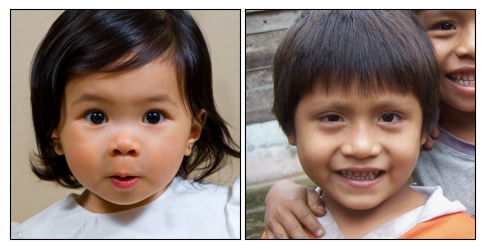

In [5]:
# %% TEST PRODUCT-CONVOLUTION
path_1 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00003.png'
path_2 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00014.png'

image_1 = Image.open(path_1)
image_1 = transform.ToTensor()(image_1)

image_2 = Image.open(path_2)
image_2 = transform.ToTensor()(image_2)

image = torch.stack([image_1, image_2], dim=0).cuda()
show_images(image)

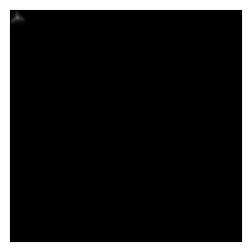

In [6]:
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)
image_size = (512, 512)
image = torch.zeros((1,3) + image_size)
image[...,30,30] = 1.
patches = image_to_patches(image, patch_size, overlap)
patch_info = compute_patch_info(image_size, patch_size, overlap)
K = patches.size(2) * patches.size(3)


generator = DiffractionBlurGenerator(
    psf_size, num_channels=3, fc=0.2, device=device, dtype=dtype)
h = torch.stack([generator.step(image.size(0))['filter']
                 for _ in range(K)], dim=0)
masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(1).unsqueeze(2)

# show_images(h.transpose(2,1).flatten(0, 1) ** 0.25, ncols=K)
blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)
show_images(blurry ** 0.25)

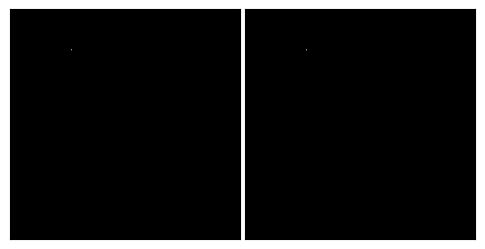

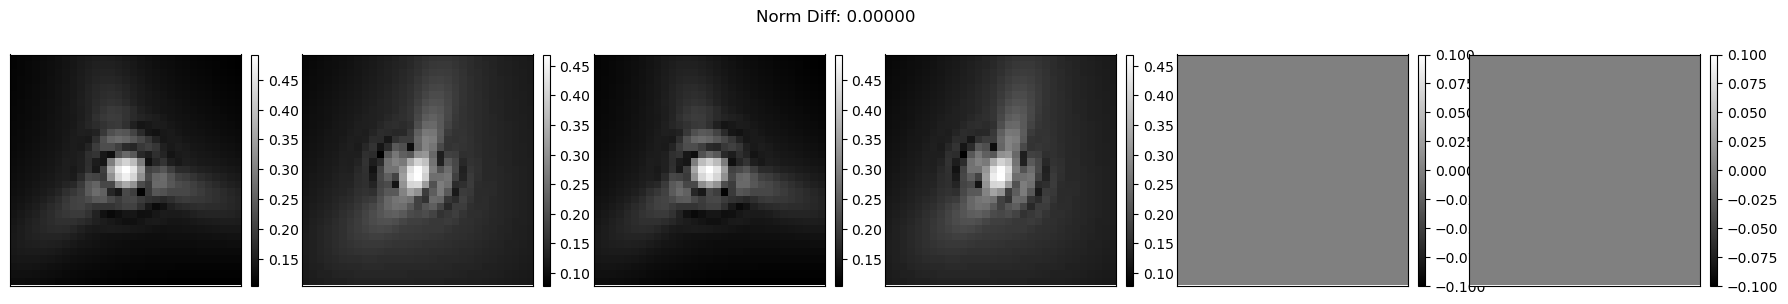

In [7]:
position = (45, 68)
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (50, 50)
image_size = 256

image = torch.zeros(2, 3, image_size, image_size)
image[..., position[0]: position[0] + 1, position[1]: position[1] + 1] = 1.
show_images(image)
info = compute_patch_info(image_size, patch_size, overlap)
K = np.prod(info['num_patches'])
masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(1).unsqueeze(2)
# w = torch.ones_like(w)
h = torch.stack([generator.step(image.size(0))['filter']
                 for _ in range(K)], dim=0)
blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)

psf_pc = blurry[..., position[0] - psf_size[0] + 1: position[0] + 1, position[1] - psf_size[1] + 1:  position[1] + 1]

patches = image_to_patches(image, patch_size, overlap)
psf = get_psf_product_convolution2d_patches(
    h, w, position, overlap, patches.shape[2:4])

diff = psf_pc[:,0:1,...] - psf[:,0:1,...]
show_images(torch.cat((psf_pc[:,0:1,...], psf[:,0:1,...], diff), dim = 0) ** 0.25, colorbar=True, suptitle=f'Norm Diff: {torch.norm(diff).item():.5f}')


In [8]:
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)
image_size = 256
image = torch.zeros(2, 3, image_size, image_size, device=device)

masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(1).unsqueeze(2)

K = np.prod(compute_patch_info(image_size, patch_size, overlap)['num_patches'])
h = torch.stack([generator.step(image.size(0))['filter']
                 for _ in range(K)], dim=0)

for i in range(psf_size[0], 256 - psf_size[0]):
    for j in range(psf_size[1], 256 - psf_size[1]):
        position = (i, j)
        image = torch.zeros(2, 3, 256, 256)
        image[..., position[0]: position[0] + 1, position[1]: position[1] + 1] = 1.
        blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)

        psf_pc = blurry[..., position[0] - psf_size[0] + 1: position[0] + 1, position[1] - psf_size[1] + 1:  position[1] + 1]

        patches = image_to_patches(image, patch_size, overlap)
        psf = get_psf_product_convolution2d_patches(
            h, w, position, overlap, patches.shape[2:4])

        diff = psf_pc[:,0:1,...] - psf[:,0:1,...]
        if torch.norm(diff) > 1e-5:
            print(f'{i, j}: ', torch.norm(diff))

## TEST ADJOINTNESS 

In [9]:
import numpy as np

image_size = 555
patch_size = 224
overlap = 80
psf_size = 31

x = torch.randn((1,3,image_size, image_size), device=device)
# x = image
patch_info = compute_patch_info(image_size, patch_size, overlap)
K = np.prod(patch_info['num_patches'])

generator = DiffractionBlurGenerator(
    (psf_size, psf_size), num_channels=3, fc=0.2, device=device, dtype=dtype)
h = torch.stack([generator.step(x.size(0))['filter']
                 for _ in range(K)], dim=0)
masks = unity_partition_function_2d(image_size, patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(1).unsqueeze(2)


Ax = product_convolution2d_patches(x, w, h, patch_size, overlap)
y = torch.randn_like(Ax)
ATy = product_convolution2d_adjoint_patches(y, w, h, patch_size, overlap)

# left = torch.sum((Ax * y)[...,psf_size//2:-psf_size//2, psf_size//2:-psf_size//2].flatten(1,-1))
left = torch.sum((Ax * y).flatten(1,-1))

max_size = patch_info['max_size']
x_crop = x[...,:max_size[0],:max_size[1]]
# right = torch.sum((ATy * x_crop)[...,psf_size//2:-psf_size//2, psf_size//2:-psf_size//2].flatten(1,-1))
right = torch.sum((ATy * x_crop).flatten(1,-1))

print('Ax: ', Ax.shape)
print('ATy: ', ATy.shape)
# print(left)
print(left - right)
print(torch.abs((left - right) / right))


Ax:  torch.Size([1, 3, 482, 482])
ATy:  torch.Size([1, 3, 512, 512])
tensor(6.1035e-05, device='cuda:0')
tensor(1.9638e-06, device='cuda:0')


## Time

In [79]:
from torch.utils.benchmark import Timer


In [4]:
psf_size = 31
image_size = 1024 
patch_size = 256 
overlap = 128
batch_size = 1
patch_info = compute_patch_info(image_size, patch_size, overlap)
K = np.prod(patch_info['num_patches'])

x = torch.randn((batch_size, 3, image_size, image_size))


generator = DiffractionBlurGenerator(
    (psf_size, psf_size), num_channels=3, fc=0.2, device=device, dtype=dtype)

masks = unity_partition_function_2d(image_size, patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(1).unsqueeze(2)

def simulate_a_batch(batch_size, image_size):
    h = generator.step(batch_size * K)['filter']
    h = h.view(K, batch_size, h.size(1), h.size(2), h.size(3))
    Ax = product_convolution2d_patches(x, w, h, patch_size, overlap)   
    

In [5]:
timer = Timer(stmt='simulate_a_batch(batch_size, image_size)',
    globals=globals())
timer.blocked_autorange(min_run_time=5)


simulate_a_batch(batch_size, image_size)
  Median: 51.92 ms
  IQR:    1.93 ms (51.14 to 53.07)
  10 measurements, 10 runs per measurement, 1 thread

device(type='cpu')

In [84]:
image_size = 1024
patch_size = 256
overlap = 128
psf_size = 31

from deepinv.physics.generator import ProductConvolutionPatchBlurGenerator
from deepinv.physics import SpaceVaryingBlur

psf_generator = DiffractionBlurGenerator(
    (psf_size, psf_size), num_channels=3, fc=0.2, device=device, dtype=dtype)

pc_generator = ProductConvolutionPatchBlurGenerator(
    psf_generator=psf_generator,
    image_size=image_size,
    patch_size=patch_size,
    overlap=overlap,
    device=device
)
params_pc = pc_generator.step(1)
physics = SpaceVaryingBlur(method="product_convolution2d_patch",
                           patch_size= patch_size, 
                           overlap=overlap,
                            **params_pc, )
physics(torch.randn(1,3,1024,1024)).shape

batch_size = 16
n_patch = 25
params = pc_generator.step(batch_size)
centers = torch.randint(patch_size //2, image_size - patch_size // 2, size = (batch_size, n_patch, 2))


In [101]:
psf = physics.get_psf(centers, **params)

In [102]:
psf_1 = physics.get_psf(centers, **params)

In [108]:
torch.allclose(psf_1.flatten(0,1), psf.flatten(0,1))

True

In [99]:
timer = Timer(stmt='physics.get_psf(centers, **params)',
    globals=globals())
timer.blocked_autorange(min_run_time=10)

physics.get_psf(centers, **params)
  Median: 236.50 ms
  IQR:    4.33 ms (234.69 to 239.02)
  42 measurements, 1 runs per measurement, 1 thread

In [100]:
timer = Timer(stmt='physics.get_psf(centers, **params)',
    globals=globals())
timer.blocked_autorange(min_run_time=10)

physics.get_psf(centers, **params)
  Median: 16.94 ms
  IQR:    0.88 ms (16.59 to 17.47)
  58 measurements, 10 runs per measurement, 1 thread

In [42]:
def func(a, b):
    return a * b

In [43]:
a = torch.randn(2,3,5,5)
b = torch.randn(2,3,5,5)
out = 0
for i in range(a.size(0)):
    for j in range(a.size(1)):
        out += func(a[i,j], b[i,j])

print(out)

tensor([[-0.0239,  3.6205, -0.8132, -2.0399, -0.8391],
        [-2.5667, -1.1048,  0.8330,  4.4954, -0.0340],
        [ 6.1241,  4.2416,  1.0668,  4.4354, -1.6159],
        [ 0.1910, -1.9419,  0.2449, -0.1489,  5.1572],
        [ 1.5072,  0.2146, -1.0960,  6.1657,  0.0330]], device='cuda:0')


In [66]:
from functools import partial
func_vmap = torch.vmap(torch.vmap(func, in_dims=(0, 0)), in_dims=(0, 0))
func_vmap(a, b).sum(dim=(0,1))

tensor([[-0.0239,  3.6205, -0.8132, -2.0399, -0.8391],
        [-2.5667, -1.1048,  0.8330,  4.4954, -0.0340],
        [ 6.1241,  4.2416,  1.0668,  4.4354, -1.6159],
        [ 0.1910, -1.9419,  0.2449, -0.1489,  5.1572],
        [ 1.5072,  0.2146, -1.0960,  6.1657,  0.0330]], device='cuda:0')